In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

We also renumber the bins so that bins 0-3 correspond to library 1, bins 4-7 correspond to library 2, and bins 8-11 correspond to library 3.

In [2]:
# Load example data
data_df = pd.read_csv('data/xylE_data.csv.gz')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 369,710
training + validation N: 1,477,518


,set,ct_0,ct_1,ct_2,ct_3,ct_4,ct_5,ct_6,ct_7,ct_8,ct_9,ct_10,ct_11,x
0,training,0,0,0,0,0,0,0,0,0,0,0,3,AAACAATAGCATTGTTCTTATCAATTTTGGATAAGTATTATAATTA...
1,training,0,0,0,0,0,0,0,0,0,0,0,5,AAACAATAGTATTGCTTTTATCAATTTAGGATAATTATCACGATTA...
2,training,0,0,0,0,0,0,0,0,0,0,0,2,AAACAATAGTATTGCTTTTATCATTTTTGGAAAATTAACACGATTA...
3,training,0,0,0,0,0,0,0,0,2,0,0,1,AAACAGGAGTATTGTTTTTAGCAATTCTGGATAATTAGCACAATTA...
4,validation,0,0,0,0,0,0,0,0,0,1,0,0,AAACCATAGTATTGTTTACATTAATTTGGGATAATTATTACAATTA...
5,validation,0,0,0,0,0,0,0,0,0,2,0,0,AAACGATAGTATCGTATTTATCATTTTTGGATAAATATCACAATTA...
6,training,0,0,0,0,0,0,0,0,1,0,0,0,AAACTATAGTATTGTTTTTATTAATTTTCGATAATTATCAAAATTA...
7,training,0,0,0,0,0,0,0,0,0,0,0,5,AAATAATTGGATTGTTTTTATCAATCTTGGAGAATTATCACAATTA...
8,training,0,0,0,0,0,0,0,0,0,0,0,6,AACAATTAGTATTGTTGTTATCAATTTTGTATAGTTATCACAATTT...
9,validation,0,0,0,0,0,0,0,0,0,0,0,1,AACCAAGAGTATTGTTTTCATCAATTTTGGATAAAGATCACAATCA...


In [3]:
# List beginning and end of each variant region, in Python coordinates
lib_coords_dict = {
    1: [97, 150],
    2: [51, 105],
    3: [0, 60]
}

In [4]:
from mavenn.src.layers.gpmap import GPMapLayer


# Tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer, Dense

class ThermodynamicLayer(GPMapLayer):
    """Represents an thermodynamic model of transcription
       regulation in E. Coli at the xylE promoter, which 
       contains binding sites for RNAP, CRP, and xylR.
    """

    def __init__(self, 
                 CRP_start,
                 CRP_end,
                 xylR_start,
                 xylR_end,
                 RNAP_start,
                 RNAP_end,
                 regularizer, 
                 *args, **kwargs):
        """Construct layer instance."""
        
        # set attributes
        self.CRP_start = CRP_start
        self.CRP_end = CRP_end        

        self.xylR_start = xylR_start
        self.xylR_end = xylR_end                        
        
        self.RNAP_start = RNAP_start
        self.RNAP_end = RNAP_end        
        
        #self.C=kwargs['C']
        self.C=4
        self.regularizer = tf.keras.regularizers.L2(regularizer)
        
        # form helpful variables
        self.L_CRP = CRP_end-CRP_start
        self.L_RNAP = RNAP_end - RNAP_start
        self.L_xylR = xylR_end - xylR_start
        
        super().__init__(*args, **kwargs)

    def build(self, input_shape):
        """Build layer."""
        
        #1 define bias/chemical potential weight for crp
        self.mu_CRP = self.add_weight(name='mu_CRP',
                                       shape=(1,),
                                       initializer=Constant(0.),
                                       trainable=True,
                                       regularizer=self.regularizer)
        
        
        #2 define bias/chemical potential weight for xylR
        self.mu_xylR = self.add_weight(name='mu_xylR',
                                       shape=(1,),
                                       initializer=Constant(0.),
                                       trainable=True,
                                       regularizer=self.regularizer)                   

        #3 define bias/chemical potential weight for rnap
        self.mu_RNAP = self.add_weight(name='mu_RNAP',
                                       shape=(1,),
                                       initializer=Constant(0.),
                                       trainable=True,
                                       regularizer=self.regularizer)
     
        

        #4 Define theta_CRP_lc parameters
        theta_CRP_lc_shape = (1, self.L_CRP, self.C)

        #theta_CRP_lc_init = np.random.randn(*theta_CRP_lc_shape)/np.sqrt(self.L_CRP)
        self.theta_CRP_lc = self.add_weight(name='theta_CRP_lc',
                                        shape=theta_CRP_lc_shape,
                                        #initializer=Constant(CRP_init_values),
                                        trainable=True,
                                        regularizer=self.regularizer)

                
        #5 Define theta_xylR_lc parameters
        theta_xylR_lc_shape = (1, self.L_xylR, self.C)

        #theta_xylR_lc_init = np.random.randn(*theta_xylR_lc_shape)/np.sqrt(self.L_xylR)
        self.theta_xylR_lc = self.add_weight(name='theta_xylR_lc',
                                        shape=theta_xylR_lc_shape,
                                        #initializer=Constant(xylR_init_values),
                                        trainable=True,
                                        regularizer=self.regularizer)        
        
        #6 Define theta_rnap_lc parameters
        theta_RNAP_lc_shape = (1, self.L_RNAP, self.C)

        #theta_RNAP_lc_init = np.random.randn(*theta_RNAP_lc_shape)/np.sqrt(self.L_RNAP)
        self.theta_RNAP_lc = self.add_weight(name='theta_RNAP_lc',
                                        shape=theta_RNAP_lc_shape,
                                        #initializer=Constant(RNAP_init_values),
                                        trainable=True,
                                        regularizer=self.regularizer)

        
        #7 define interaction term between CRP and xylR
        self.I_cx = self.add_weight(name='I_cx',
                               shape=(1,),
                               initializer=Constant(-1),
                               trainable=True)
        
        #8 define interaction term between RNAP and xylR. 
        self.I_rx = self.add_weight(name='I_rx',
                               shape=(1,),
                               initializer=Constant(-1),
                               trainable=True,
                               regularizer=self.regularizer)
        
#         #9 define interaction term between CRP and RNAP
#         self.I_cr = self.add_weight(name='I_cr',
#                                shape=(1,),
#                                initializer=Constant(-1),
#                                trainable=True)        
        
#         #10 define tsat term. 
        self.tsat = self.add_weight(name='tsat',
                               shape=(1,),
                               initializer=Constant(1.),
                               trainable=False)        
        
        # Call superclass build
        super().build(input_shape)

    def call(self, x_lc):
        """Process layer input and return output.
        
        x_lc: (tensor)
            Input tensor that represents one-hot encoded 
            sequence values. 
        """
        
        # extract locations of binding sites from entire lac-promoter sequence.
        x_CRP_lc = x_lc[:,self.C * self.CRP_start:self.C * self.CRP_end]
        x_xylR_lc = x_lc[:,self.C * self.xylR_start: self.C * self.xylR_end]
        x_RNAP_lc = x_lc[:,self.C * self.RNAP_start: self.C * self.RNAP_end]
        
        # reshape according to crp and rnap lengths. 
        x_CRP_lc = tf.reshape(x_CRP_lc, [-1, self.L_CRP, self.C])
        x_xylR_lc = tf.reshape(x_xylR_lc, [-1, self.L_xylR, self.C])        
        x_RNAP_lc = tf.reshape(x_RNAP_lc, [-1, self.L_RNAP, self.C])

                
        # compute delta G for crp    
        phi_CRP = self.mu_CRP + \
              tf.reshape(K.sum(self.theta_CRP_lc * x_CRP_lc, axis=[1, 2]),
                         shape=[-1, 1])
            
        # compute delta G for LacI
        phi_xylR = self.mu_xylR + \
              tf.reshape(K.sum(self.theta_xylR_lc * x_xylR_lc, axis=[1, 2]),
                         shape=[-1, 1])                             
            
        # compute delta G for rnap
        phi_RNAP = self.mu_RNAP + \
              tf.reshape(K.sum(self.theta_RNAP_lc * x_RNAP_lc, axis=[1, 2]),
                         shape=[-1, 1])                   
        
        # partition function
        Z = (1+K.exp(-phi_CRP)+K.exp(-phi_xylR)+ \
             K.exp(-phi_RNAP)+ \
             K.exp(-phi_xylR-phi_RNAP-self.I_rx)+ \
             #K.exp(-phi_CRP-phi_RNAP-self.I_cr)+ \
             K.exp(-phi_CRP-phi_RNAP)+ \
             K.exp(-phi_CRP-phi_xylR-phi_RNAP-self.I_cx-self.I_rx) +\
             K.exp(-phi_CRP-phi_xylR-self.I_cx)
            )
        
        transcription_states =  K.exp(-phi_RNAP)+ \
                                K.exp(-phi_xylR-phi_RNAP-self.I_rx)+ \
                                K.exp(-phi_CRP-phi_RNAP)+ \
                                K.exp(-phi_CRP-phi_xylR-phi_RNAP-self.I_cx-self.I_rx)
        
        
        
        # compute rate of transcription
        t = (self.tsat)*(transcription_states)/Z
        
        
        # return rate of transcription
        return t

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet=['A','C','G','T']

y_cols = data_df.columns[1:-1]
Y = len(y_cols)
print(f'L={L}, Y={Y}')

# get test set data.
x_test = test_df['x'].values

L=150, Y=12


In [6]:
gpmap_kwargs = {'L':L,
                #'C':4,
                'theta_regularization': 0.05,
                'CRP_start':37,
                'CRP_end':57,
                'xylR_start':58,
                'xylR_end':89,
                'RNAP_start':91,
                'RNAP_end':122,
                'regularizer':0.05}

In [7]:
# instantiate gpmap object
#gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)

therodynamic_gpmap = ThermodynamicLayer(alphabet=alphabet,**gpmap_kwargs)

In [8]:
therodynamic_gpmap

### Create measurement process object(s)

In [9]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_mpa_1 = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)

mp_mpa_2 = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)

mp_mpa_3 = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=4,
                                                                      K=50,
                                                                      eta=1e-5,)


In [10]:
model = mavenn.Model2(gpmap=therodynamic_gpmap,
                      mp_list=[mp_mpa_1, mp_mpa_2, mp_mpa_3])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (<unknown>, line 34)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (<unknown>, line 34)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-04-01 21:01:24.815336: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 612)]       0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 600)          0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 thermodynamic_layer (Thermodyn  (None, 1)           334         ['Sequence_only[0][0]']          
 amicLayer)                                                                                       
                                                                                              

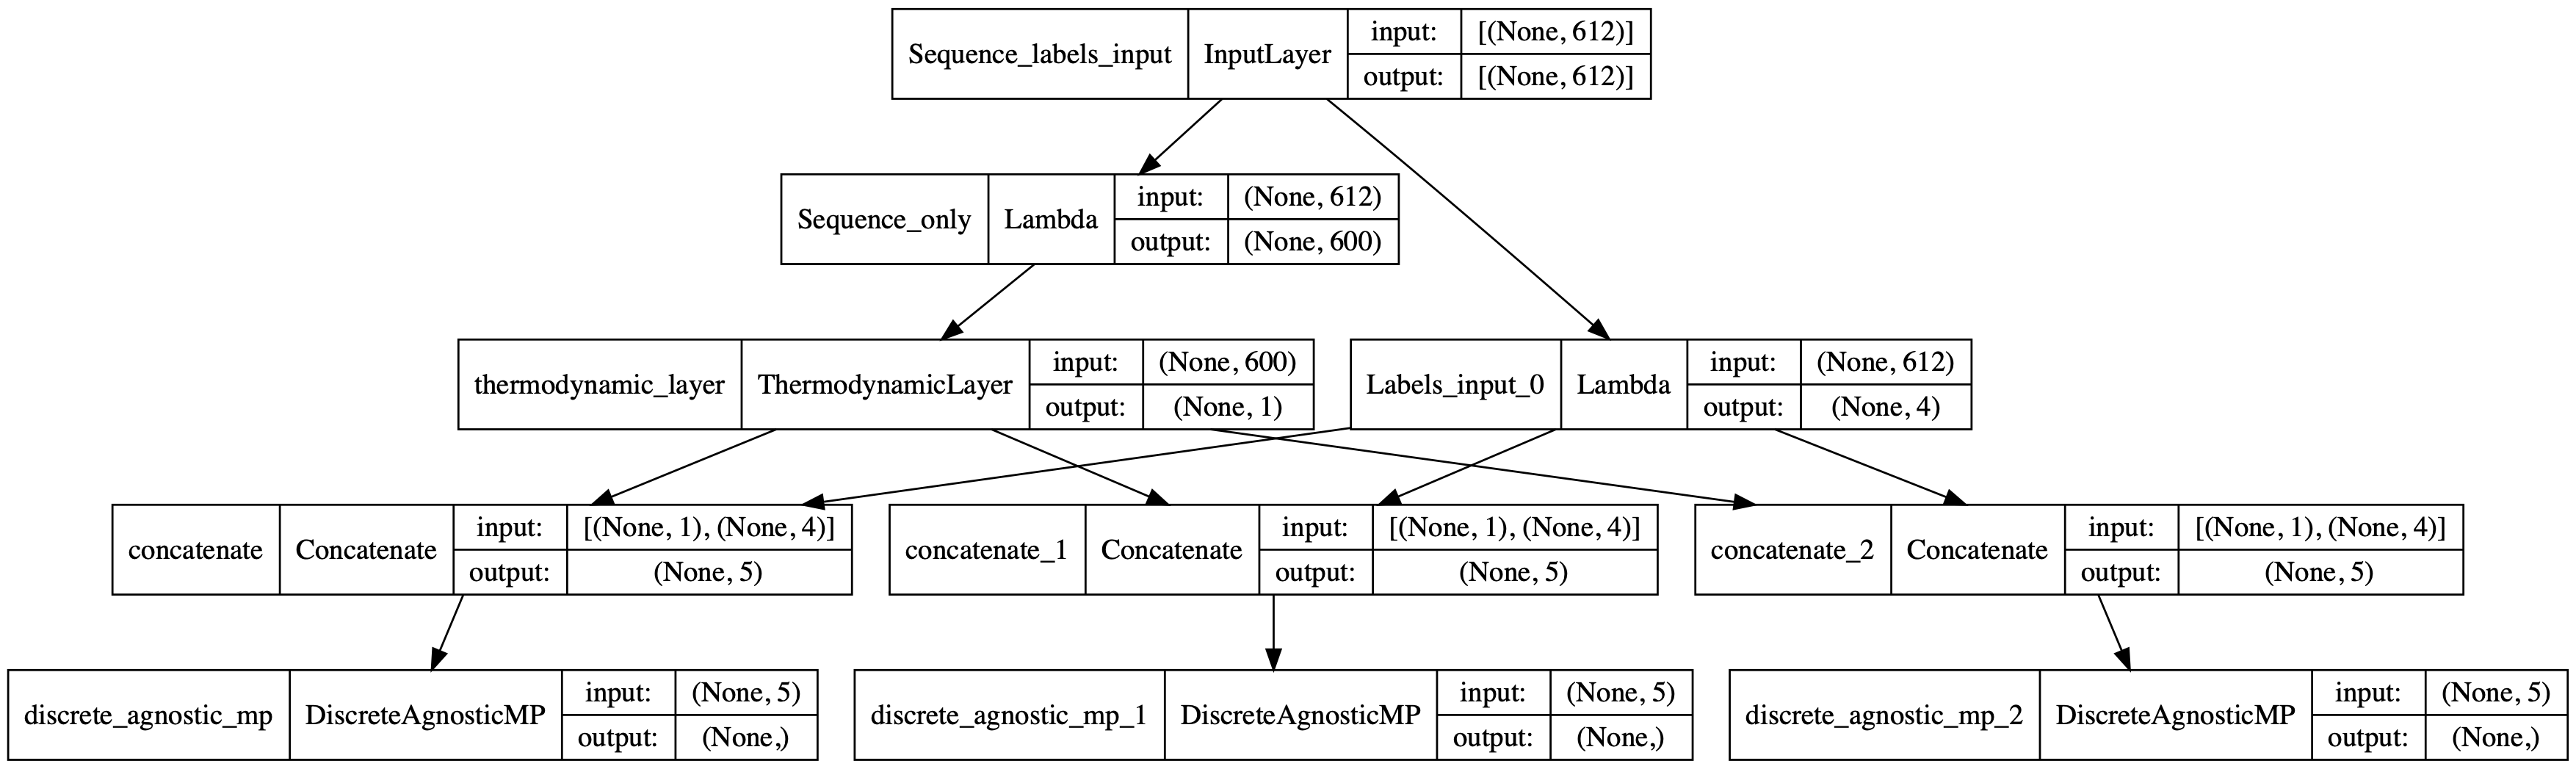

In [12]:
from tensorflow.keras.utils import plot_model
plot_model(model.model,show_shapes=True,show_dtype=False,dpi=200)

In [13]:
# Set training data
model.set_data(x=data_df['x'].values,
               y_list=[data_df[y_cols[0:4]].values,data_df[y_cols[4:8]].values,data_df[y_cols[8:12]].values],
               validation_flags=(data_df['set']=='validation'),
               shuffle=False)


N = 1,477,518 observations set as training data.
Using 25.0% for validation.
Time to set data: 1.02e+02 sec.


In [14]:

# Fit model to data
model.fit(learning_rate=.005,
          epochs=25,
          batch_size=1000,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/25
1108/1108 [==============================] - 40s 33ms/step - loss: 4820.2466 - discrete_agnostic_mp_loss: 1605.9359 - discrete_agnostic_mp_1_loss: 1606.1161 - discrete_agnostic_mp_2_loss: 1606.9680 - I_var: 0.5098 - val_loss: 4505.1694 - val_discrete_agnostic_mp_loss: 1500.7742 - val_discrete_agnostic_mp_1_loss: 1501.2333 - val_discrete_agnostic_mp_2_loss: 1501.3947 - val_I_var: nan
Epoch 2/25
1108/1108 [==============================] - 33s 29ms/step - loss: 4610.4604 - discrete_agnostic_mp_loss: 1536.0862 - discrete_agnostic_mp_1_loss: 1536.1594 - discrete_agnostic_mp_2_loss: 1536.1158 - I_var: 0.5751 - val_loss: 4503.6924 - val_discrete_agnostic_mp_loss: 1500.1483 - val_discrete_agnostic_mp_1_loss: 1500.3425 - val_discrete_agnostic_mp_2_loss: 1500.7808 - val_I_var: nan
Epoch 3/25
1108/1108 [==============================] - 26s 24ms/step - loss: 4598.3955 - discrete_agnostic_mp_loss: 1532.0273 - discrete_agnostic_mp_1_loss: 1531.9664 - discrete_agnostic_mp_2_loss: 1531.64

Epoch 22/25
1108/1108 [==============================] - 23s 21ms/step - loss: 4559.5518 - discrete_agnostic_mp_loss: 1517.3804 - discrete_agnostic_mp_1_loss: 1517.3082 - discrete_agnostic_mp_2_loss: 1517.5353 - I_var: 0.5933 - val_loss: 4448.6519 - val_discrete_agnostic_mp_loss: 1480.2590 - val_discrete_agnostic_mp_1_loss: 1480.3688 - val_discrete_agnostic_mp_2_loss: 1480.5723 - val_I_var: nan
Epoch 23/25
1108/1108 [==============================] - 22s 20ms/step - loss: 4555.9048 - discrete_agnostic_mp_loss: 1516.0741 - discrete_agnostic_mp_1_loss: 1516.0702 - discrete_agnostic_mp_2_loss: 1516.3225 - I_var: 0.5943 - val_loss: 4465.5278 - val_discrete_agnostic_mp_loss: 1485.7440 - val_discrete_agnostic_mp_1_loss: 1485.8702 - val_discrete_agnostic_mp_2_loss: 1486.3450 - val_I_var: nan
Epoch 24/25
1108/1108 [==============================] - 20s 18ms/step - loss: 4557.5483 - discrete_agnostic_mp_loss: 1516.4928 - discrete_agnostic_mp_1_loss: 1516.6700 - discrete_agnostic_mp_2_loss: 1516

On test data:


Text(0.5, 1.0, 'training hisotry')

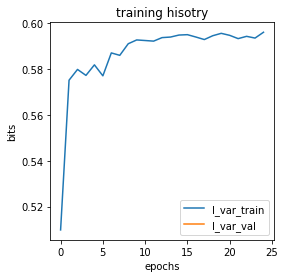

In [17]:
# Show training history
print('On test data:')
x_test = test_df['x'].values
y_test = test_df[y_cols].values


I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

In [23]:
interaction_term = model.model.layers[2].get_weights()[4]
crp_weights = np.squeeze(model.model.layers[2].theta_CRP_lc.numpy())
xylR_weights = np.squeeze(model.model.layers[2].theta_xylR_lc.numpy())
rnap_weights = np.squeeze(model.model.layers[2].theta_RNAP_lc.numpy())

I_cx = model.model.layers[2].I_cx.numpy()[0]
I_rx = model.model.layers[2].I_rx.numpy()[0]
#print(f'interaction term = {interaction_term[0]:.3f} k_bT')

In [26]:
crp_df = pd.DataFrame(crp_weights,columns=alphabet)
xylR_df = pd.DataFrame(xylR_weights,columns=alphabet)
rnap_df = pd.DataFrame(rnap_weights,columns=alphabet)

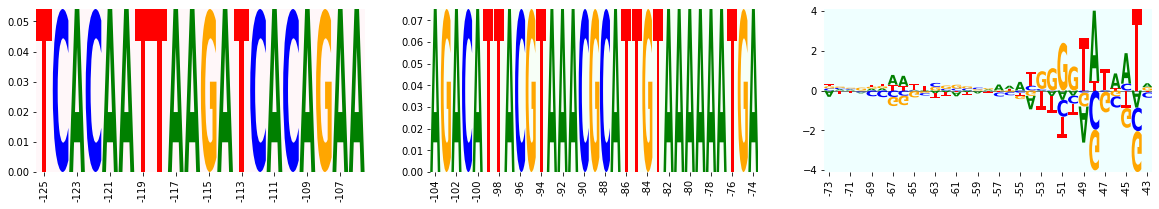

In [30]:
# # Get G-P map parameters in matrix form
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
# Y = model.model.Y    # Y = number of bins
# y_lim = [-.5, Y-.5]
# y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = model.p_of_y_given_phi(y_all, phi_grid)

# # Create figure with two panels
fig, axs = plt.subplots(1,3,figsize=[20,3])

tick_spacing=2
crp_logo  = logomaker.Logo(-crp_df,ax=axs[0],center_values=False)
crp_logo.style_xticks(anchor=0, spacing=tick_spacing, rotation=90)
crp_logo.style_spines(visible=False)
crp_logo.highlight_position_range(0,21,alpha=0.5,color='lavenderblush',label='CRP')
#crp_logo.style_glyphs_in_sequence(sequence='.TGTGA......TCACA...', color='darkred')
crp_logo.ax.set_xticklabels('%+d'%x for x in np.arange(-125,-107+1,tick_spacing))

xylR_logo = logomaker.Logo(xylR_df,ax=axs[1],center_values=False)
xylR_logo.style_xticks(anchor=0, spacing=tick_spacing, rotation=90)
xylR_logo.style_spines(visible=False)
xylR_logo.ax.set_xticklabels('%+d'%x for x in np.arange(-104,-74+1,tick_spacing))
xylR_logo.highlight_position_range(0,31,alpha=0.5,color='honeydew',label='RNAP')

rnap_logo = logomaker.Logo(-rnap_df,ax=axs[2],center_values=True)
rnap_logo.style_xticks(anchor=0, spacing=tick_spacing, rotation=90)
rnap_logo.style_spines(visible=False)
rnap_logo.highlight_position_range(0,31,alpha=0.5,color='lightcyan',label='RNAP')
rnap_logo.ax.set_xticklabels('%+d'%x for x in np.arange(-73,-42+1,tick_spacing))
plt.show()
# # # Right panel: draw measurement process as heatmap